In [1]:
import pandas as pd
import numpy as np
import zipcode
import uszipcode
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from uszipcode import ZipcodeSearchEngine
### We will also need to suppress the scientific notation display to generate/restore floating point values
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
from math import log, exp
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn import grid_search
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

C:\Users\Nj_neeraj\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Nj_neeraj\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv('C:/Users/Nj_neeraj/Documents/re_data.csv')

In [3]:
df.dtypes
# to change zip to object/character 
df['Zip'] = df.Zip.astype(object)
###first we remove empty cells
df['Year Built'].replace('', np.nan, inplace=True)
df.dropna(subset=['Year Built'], inplace=True)

In [4]:
## we notice the year column also has multiple entries in the same cell, we will remove them as well.
df[df['Year Built'].str.contains(",")]
df = df[df['Year Built'].str.contains(",") == False]

In [5]:
#check for nan values.
zip=df['Zip']
pd.isnull(zip).sum() > 0
##subset data with non-nan values in zip column
df_zipsub = df.dropna()
#df_zipsub = df[pd.notnull(df['Zip'])]
##check again for nan values.
zips=df_zipsub['Zip']
pd.isnull(zips).sum() > 0

False

In [6]:
##now create states from zip
zips=zips.astype(int)
zips=zips.astype(str)
states = pd.DataFrame()
zipcode = pd.DataFrame()
for i in zips:
    search = ZipcodeSearchEngine()
    myzip = search.by_zipcode(i)
    if myzip:
        state = (myzip.State).split()
        states = states.append(state)
        zipp = (myzip.Zipcode).split()
        zipcode = zipcode.append(zipp)
        combine =  pd.concat([states, zipcode], ignore_index=True, axis=1)

In [7]:
combine.columns = ['State','Zip']
combine = combine.reset_index(drop=True)

In [8]:
df_zipsub['Zip'] = df_zipsub['Zip'].astype(int)
df_zipsub['Zip'] = df_zipsub['Zip'].astype(str)
df_new = pd.merge(df_zipsub,combine, on = 'Zip', how= 'left')
df_new=df_new.drop_duplicates() 
#df_new.sort_values(by=['First Payment Date'], ascending=[True])
#df_new = df_new.dropna()

C:\Users\Nj_neeraj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Nj_neeraj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
### We find if there are NA rows.
null_data = df_new[df_new.isnull().any(axis=1)]
### We are able to see that there are rows for which 'State' columns returns NaN values because of 'invalid type' zipcodes.
### so we will remove them from our dataset now.
df_new = df_new.dropna()
### Now we have clean dataset and we will reste the index one more time for clarity and readability purpose.
df_new = df_new.reset_index(drop=True)

In [10]:
### Lets first find out which state has highest average loan amount

average = df_new.groupby(['State']).mean()
average = average[['Loan Amount']]
##Sort it descending order to see which state has highest value.
average.sort_values(by=['Loan Amount'], ascending=[False])

,Loan Amount
State,
OH,18849807.25
UT,18102120.49
AR,14091579.64
GA,13069454.84
PA,12725051.52
NC,12610142.89
AZ,10718642.73
LA,10110782.63
VA,10030664.03


In [11]:
## We can clearly see Ohio has the highest average loan amount.
## We can visualize it now to make the comparison clear.
sns.set(style="whitegrid", color_codes=True)

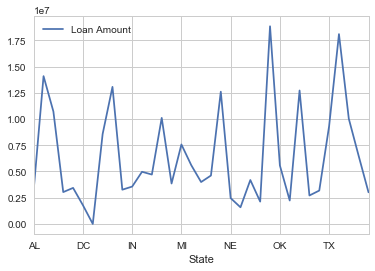

In [12]:
average.reset_index().plot(x='State', y='Loan Amount')

In [13]:
### taxes as a % of property value
## df_new.dtypes shows that 'Property Value' column intead of Floating point, which gives the indication the column has erroneous 
## values stored along as well, we can confirm our assumption using the following

#df_new['Property Value'] = df_new['Property Value'].astype(float)
## Above line of code will throw error suggesting there are values such as 'Error' stored in the column.
##Following line of code confirms the same.

df_new[df_new['Property Value'].str.contains("Error")]
### Now we will remove thr errorneous rows from our dataset.
df_new = df_new[df_new['Property Value'].str.contains("Error") == False]

### Now we can convert object type to floating point for calculation.
df_new['Property Value'] = df_new['Property Value'].astype(float)
df_new['Tax_Percent'] = (df_new['Taxes Expense']/df_new['Property Value'])*100

In [14]:
state_tax = df_new[['State','Tax_Percent']]
state_tax.sort_values(by=['Tax_Percent'], ascending=[False])
### At this point our assumption that data is cleaned is challenged as we find an 'Inf' value for State Florida because it has
### the value '0' stored in 'Property Value' column, therefore we will delete this row from the original dataframe to clean it further.
df_new = df_new[df_new['Property Value'] != 0]
##calling above line of codes again to see the data without Inf values now.
state_tax = df_new[['State','Tax_Percent', 'Property Value', 'Taxes Expense', 'Zip', 'Loan Amount']]
state_tax.sort_values(by=['Tax_Percent'], ascending=[False])

### We can clearly see Illinois has highest tax percent per property value. We can also see that many states are repeated in
### the sequence which is because of different zip codes that these property belong to, and price of each property can genuinely differ
### as some location might more expensive than others within the same state.

#df_new[df_new['Taxes Expense']==0]
#df_new[df_new['Effective Gross Income']==0]

### We also notice there are values in 'Taxes Expense' that are 0, now we may argue, can tax expenses be 0? For the sake of 
### 'real world' scenario we know it can not be, and we would want to delete these rows from original dataset again. However
### another argument we can made is, when we are trying to find the amount to lend a candidate profile, do we want to also,
### find out when we can not lend any money at all? such as the case with loan amount as 0, or do we only want to focus on 
### actual non-zero amount to lend someone. If we want to do the former, then we might want to keep 0 values in Taxes expense and 
### other columns/variables as well. This is subjective and for now, we will keep it simple with our given understanding.


,State,Tax_Percent,Property Value,Taxes Expense,Zip,Loan Amount
636,IL,4.22,5284676.64,223273.32,60429,3827544.54
399,TX,3.80,2230856.05,84670.91,76712,1563495.43
508,NY,3.76,1165578.24,43868.78,10466,0.00
762,NY,3.58,18048474.23,646764.13,13790,1833721.99
349,MI,3.16,4140528.70,130734.27,49008,3140801.64
133,NY,3.10,5182080.85,160797.64,14304,4018228.87
382,MI,3.00,5264470.73,157950.78,49006,4008371.11
627,NY,2.99,11966412.29,357456.42,11706,4737873.67
313,MI,2.88,16010448.88,461175.59,48075,11069443.10
576,TX,2.70,17013198.21,458853.63,76137,13404699.27


In [15]:
### Maintenance as a percentage of property value.
df_new['Maintenance_Percent'] = (df_new['Maintenance Expense']/df_new['Property Value'])*100

In [16]:
### Easiest ad simplest way to find the strong predictors, is corrlation matrix or scatter plot matrix that describes the 
### dependencies and relation between two variables to each other.

df_maintenance = df_new[df_new.columns.difference(['Maintenance_Percent','Tax_Percent'])]
#print(df_maintenance.corr())
### Now if we just look at the 'Maintenance Expense' then we can see 'Total Operating Expenses' is strongest predictor with 91% 
### positive correlation.
### However in order to find the strong predictor(s) for 'Maintenance_Percent', we will remove Maintenance Expenses and 
### Property Value column, since it is directly derived from them. Additionally we will remove 'Tax_percent' column as well,
### since it is a derived variable as well (not i original dataset) and was obtained from Property Value varibale as well.
df_maintenance = df_new[df_new.columns.difference(['Maintenance Expense','Property Value','Tax_Percent'])]
print(df_maintenance.corr())

### From this we can see and interpret there are no 'strongest' predictor for Maintenance_Percent, the relation with other variables is fairly low
### and this indicates, the Maintenance_Percent is not a very useful variable for us to keep as well.
### However to answer the original question, the strongest predictor from the list is 'Insurance Expensse' with 29%, cloely followed by
### 'Total Operating Expenses' with 27% of relation. Note, 'Total Operating Expenses' was strongest predictor for 'Maintenance Expense'
### variable.

                          Effective Gross Income  Insurance Expense  \
Effective Gross Income                      1.00               0.80   
Insurance Expense                           0.80               1.00   
Loan Amount                                 0.83               0.62   
Maintenance_Percent                         0.16               0.29   
Net Operating Income                        0.98               0.74   
Parking Expense                             0.31               0.29   
Payroll Expense                             0.86               0.70   
Taxes Expense                               0.89               0.73   
Total Operating Expenses                    0.97               0.84   
Utilities Expense                           0.60               0.58   

                          Loan Amount  Maintenance_Percent  \
Effective Gross Income           0.83                 0.16   
Insurance Expense                0.62                 0.29   
Loan Amount                     

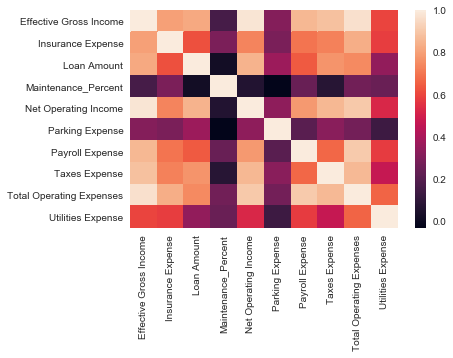

In [17]:
corr = df_maintenance.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [18]:
df_maintenance.head()

,Effective Gross Income,First Payment Date,Insurance Expense,Loan Amount,Maintenance_Percent,Maturity Date,Net Operating Income,Parking Expense,Payroll Expense,State,Taxes Expense,Total Operating Expenses,Utilities Expense,Year Built,Zip
0,282027.80,2017-06-01,9110.30,2143864.02,0.63,2022-05-01,153643.96,4608.95,12215.12,IL,41580.76,125597.78,11233.91,1965,60077
1,180649.26,2017-06-01,13001.24,1445991.78,0.79,2037-05-01,105282.69,0.00,0.00,FL,32705.82,75213.72,0.00,1960,33441
2,305261.44,2017-06-01,3869.46,2725017.88,0.70,2037-05-01,230180.51,0.00,0.00,CA,39049.76,71830.08,381.04,1959,94597
3,890801.66,2017-07-01,11441.55,4203448.93,1.09,2037-06-01,509272.80,0.00,104574.43,CA,51614.93,417618.92,25899.44,1976,95670
4,101021.26,2017-06-01,3008.81,872183.47,0.55,2027-05-01,68206.10,0.00,0.00,CA,11057.87,34641.78,6592.98,1952,90008


In [19]:
### Now we can also confirm that Maintenance_Percent doe snot have strong relation with any predictor, we can use Anova test for
### the same and notice R-squared value to be very low for any consideration.
### In addition notice F-statistice value is not high at all, hence we can conclude our hypothesis in the favor of null relation between
### Maintenance_Percent and Insurance Expenses, similarly for Total Operating Expenses

#ANOVA F Test

model = smf.ols(formula='Maintenance_Percent ~ df_maintenance["Insurance Expense"]', data=df_maintenance)
results = model.fit()
print (results.summary())
model = smf.ols(formula='Maintenance_Percent ~ df_maintenance["Total Operating Expenses"]', data=df_maintenance)
results = model.fit()
print (results.summary())

                             OLS Regression Results                            
Dep. Variable:     Maintenance_Percent   R-squared:                       0.086
Model:                             OLS   Adj. R-squared:                  0.084
Method:                  Least Squares   F-statistic:                     76.69
Date:                 Wed, 13 Dec 2017   Prob (F-statistic):           1.13e-17
Time:                         21:26:00   Log-Likelihood:                -794.73
No. Observations:                  822   AIC:                             1593.
Df Residuals:                      820   BIC:                             1603.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [20]:
median= df_new['Loan Amount'].median()
range_ = (df_new['Loan Amount'].max() - df_new['Loan Amount'].min())
var = df_new['Loan Amount'].var()
### We can obtain the same with describe(summary statistic)
df_new['Loan Amount'].describe()
### Calculation of loan amount from the above statistics look highly un-deterministic, rather probabilistic.
df_new.columns

Index(['First Payment Date', 'Maturity Date', 'Loan Amount', 'Zip',
       'Property Value', 'Year Built', 'Net Operating Income',
       'Effective Gross Income', 'Total Operating Expenses',
       'Maintenance Expense', 'Parking Expense', 'Taxes Expense',
       'Insurance Expense', 'Utilities Expense', 'Payroll Expense', 'State',
       'Tax_Percent', 'Maintenance_Percent'],
      dtype='object')

In [21]:
df1 = df_new[['Property Value','Total Operating Expenses',
       'Maintenance Expense', 'Parking Expense', 'Taxes Expense',
       'Insurance Expense', 'Utilities Expense', 'Payroll Expense']]

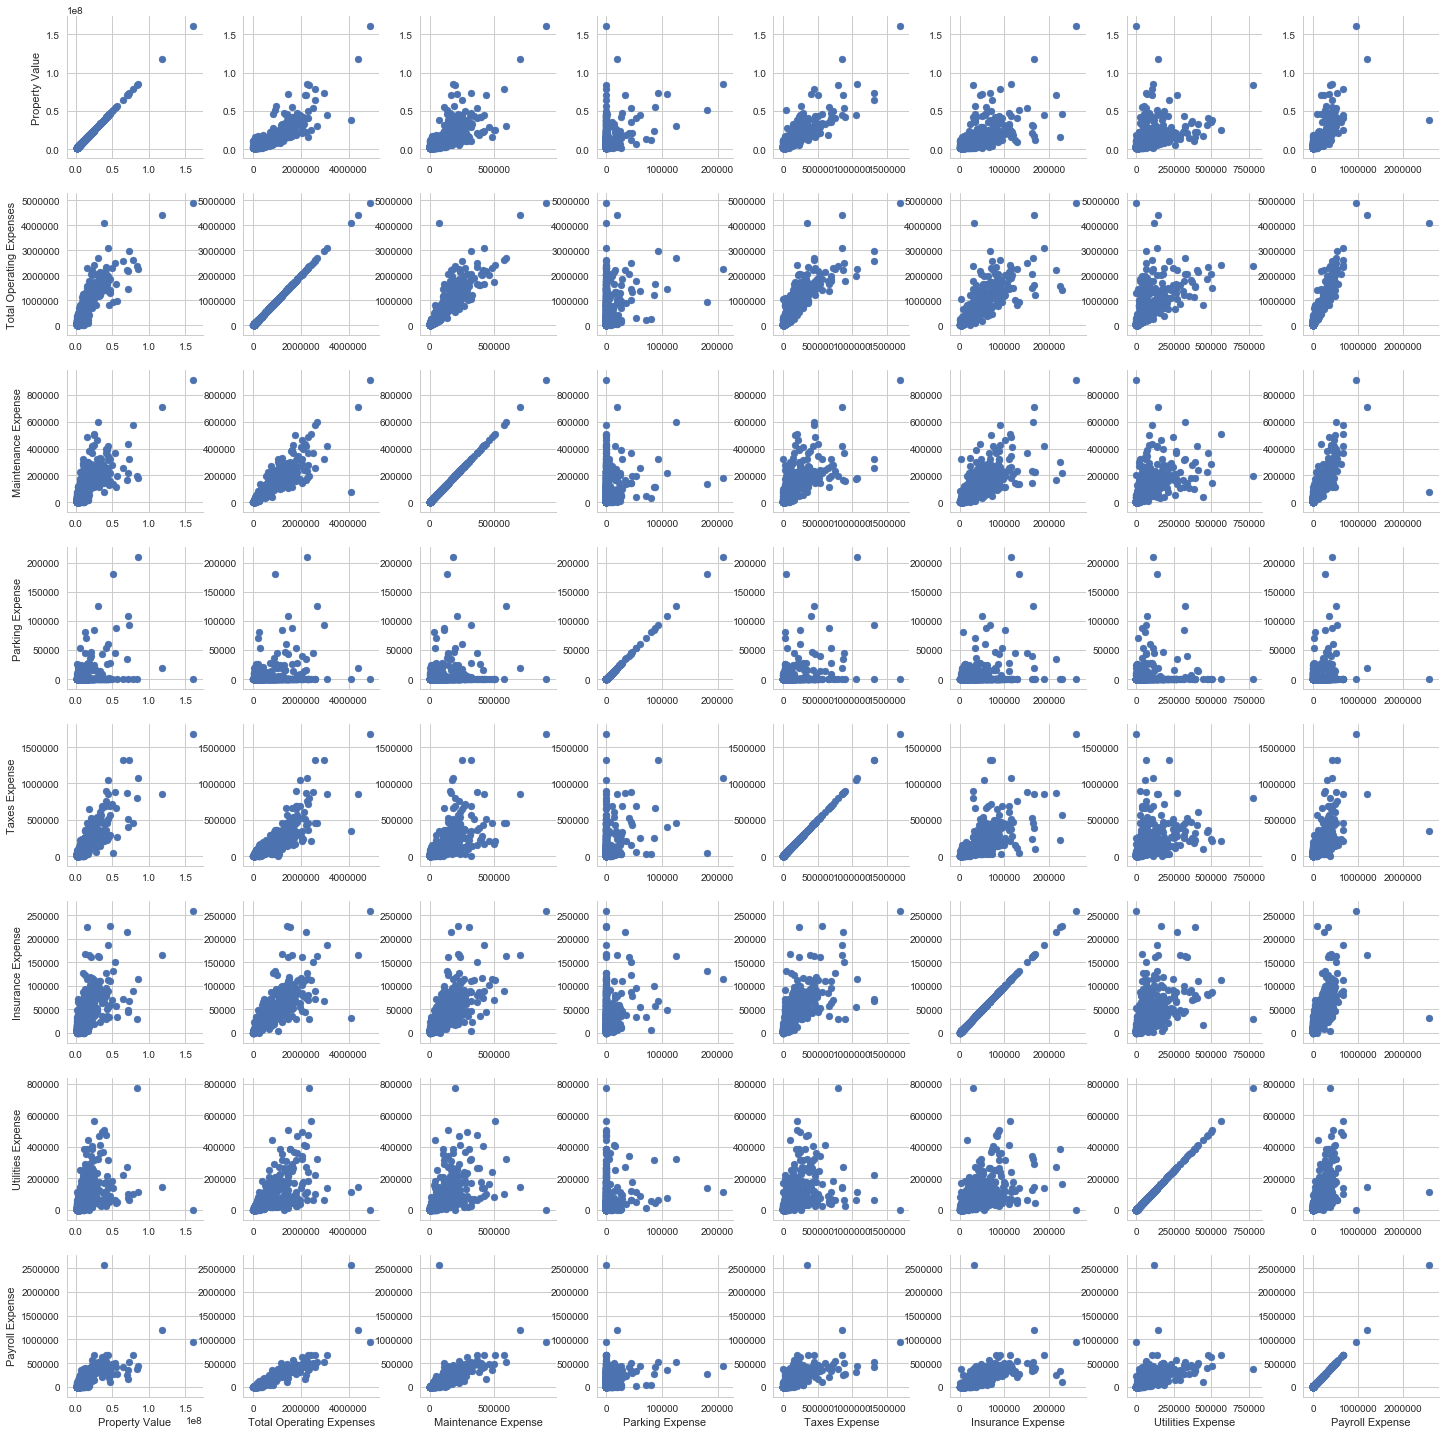

In [22]:
g = sns.PairGrid(df1)
g.map(plt.scatter);

In [23]:
df1.corr()

,Property Value,Total Operating Expenses,Maintenance Expense,Parking Expense,Taxes Expense,Insurance Expense,Utilities Expense,Payroll Expense
Property Value,1.00,0.87,0.78,0.38,0.86,0.70,0.49,0.73
Total Operating Expenses,0.87,1.00,0.91,0.27,0.87,0.84,0.66,0.91
Maintenance Expense,0.78,0.91,1.00,0.20,0.72,0.79,0.58,0.78
Parking Expense,0.38,0.27,0.20,1.00,0.33,0.29,0.14,0.21
Taxes Expense,0.86,0.87,0.72,0.33,1.00,0.73,0.47,0.67
Insurance Expense,0.70,0.84,0.79,0.29,0.73,1.00,0.58,0.70
Utilities Expense,0.49,0.66,0.58,0.14,0.47,0.58,1.00,0.58
Payroll Expense,0.73,0.91,0.78,0.21,0.67,0.70,0.58,1.00


In [24]:
### From the scatter plot (first column) and the correlation matrix (first column), we are able to find certain pattern.
### We see that property value has very high linear trending relation with 'Total Operating Expenses', 'Maintenance Expenses',
### 'Taxes Expenses', somewhat strong linear upward trending relation with 'Payroll expense', 'Insurance Expense',, and very less,
### and more scatterted (less linear) trending relation with 'Parking Expense' and 'Utilities Expense'.

### What we can say from this, is that with the Expenses, Property Value shows strong upward trending relation, are able to exhibit 
### economic relation, where Higher Property value generally would mean Higher Expenses in terms of Total Operation, Maintenance
### and higher taxes, somewhat Higher Payroll as well to compensate for location and property value, and somehwat higher insurance expenses.
### To Summarize, this basically confirms our assumptions, that the locations (zipcodes), with higher property value are by default
### more expensive overall than locations with lower property values.

### We can also try to add all the expenses together as one and see their combined relation with property value.
df1['Total_Expenses'] =df1['Total Operating Expenses'].values + df1['Maintenance Expense'].values + df1['Parking Expense'].values +df1['Taxes Expense'].values + df1['Insurance Expense'].values + df1['Utilities Expense'].values + df1['Payroll Expense'].values

C:\Users\Nj_neeraj\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


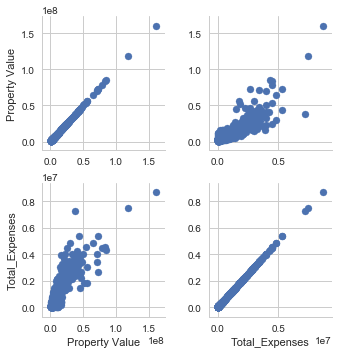

In [25]:
df1[['Property Value', 'Total_Expenses']].corr()
g = sns.PairGrid(df1[['Property Value', 'Total_Expenses']])
g.map(plt.scatter);

### We are able to confirm, higher property value means higher expenses. Property values are usually higher in mmore expensive locations/areas,
### hence higher cost of overall living.

In [26]:
df_new['Expense_ratio'] = df_new['Total Operating Expenses']/df_new['Effective Gross Income']

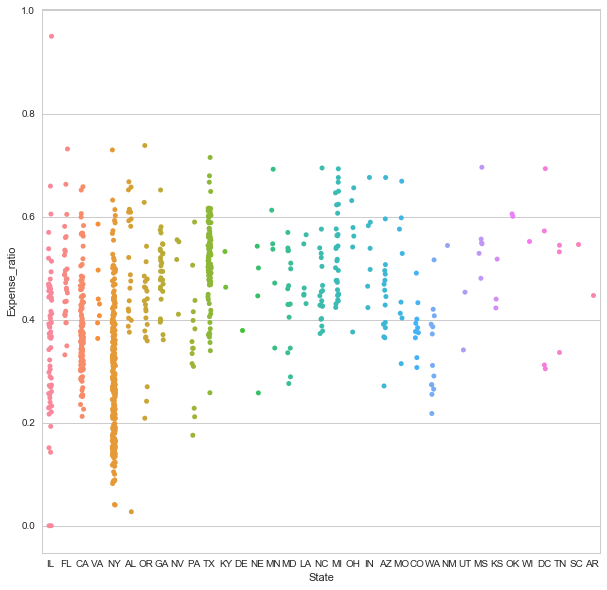

In [27]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.stripplot(x="State", y="Expense_ratio", data=df_new, jitter=True, ax= ax);

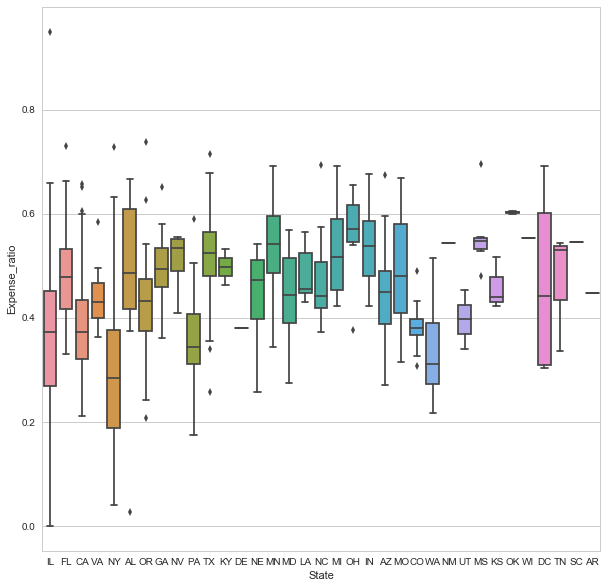

In [28]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.boxplot(x="State", y="Expense_ratio", data=df_new, ax=ax);

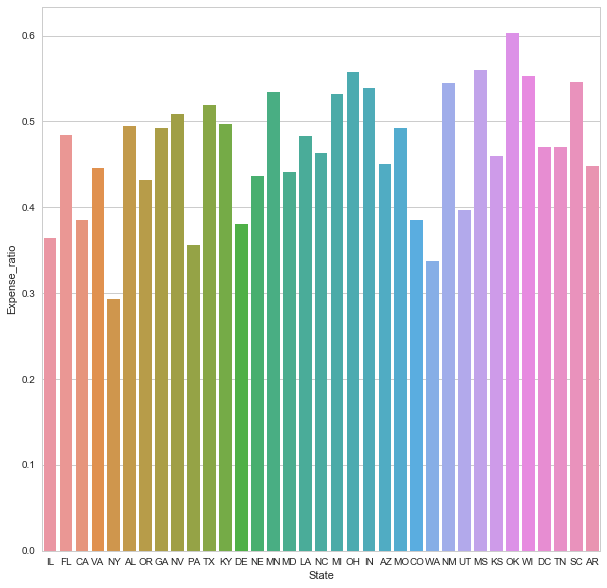

In [29]:
fig, ax = plt.subplots(figsize=(10,10)) 
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.barplot(x="State", y="Expense_ratio", data=df_new,ci=None, ax = ax)

In [30]:
### We can see from all 3 plots that states on the right side have higher expense ratio concentration, higher than mean value 
df_new['Expense_ratio'].mean()
### A stand out observation from this is of NY state, which has lowest Expense ration compared to other states.

0.4027492371038849

In [31]:
df_new.head()
df2 = df_new[['Year Built','Total Operating Expenses',
       'Maintenance Expense', 'Parking Expense', 'Taxes Expense',
       'Insurance Expense', 'Utilities Expense', 'Payroll Expense']]
df2['Total_Expenses'] =df2['Total Operating Expenses'].values + df2['Maintenance Expense'].values + df2['Parking Expense'].values +df2['Taxes Expense'].values + df2['Insurance Expense'].values + df2['Utilities Expense'].values + df2['Payroll Expense'].values

C:\Users\Nj_neeraj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [32]:
#df_new.to_csv('C:/Users/Nj_neeraj/Documents/clean_data.csv', sep=',')
df2.to_csv('C:/Users/Nj_neeraj/Documents/expense_year.csv', sep=',')
###link to plot for Expenses vs Year Built. 
### We ae able to clearly identify the pattern where we see that as years roll by,the overall expenses are increasing.
### From less than a million in year 1940 and below, to close to 5 million and above, for succesive years.
### correlation between expenses and year for property comes out ot be .42
#https://plot.ly/~neeraj10/13/

In [33]:
###Create fiscal quarter
df_new['First Payment Date'] = pd.to_datetime(df_new['First Payment Date'])
df_new['Maturity Date'] = pd.to_datetime(df_new['Maturity Date'])
df_new['Quarter'] = df_new['First Payment Date'].dt.quarter
df_new['Year']  = df_new['First Payment Date'].dt.year
df_new['Year'] = df_new['Year'].astype(object)
df_new['Quarter'] = df_new['Quarter'].astype(object)
df_new['Quarter'] = df_new["Year"].map(str) + "_" +df_new["Quarter"].map(str)
df3 = df_new[['Loan Amount', 'Quarter']]

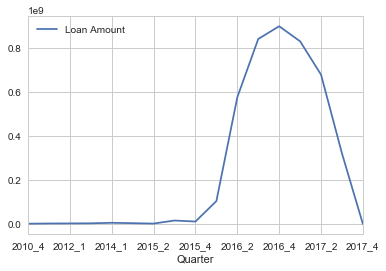

In [34]:
quarter_cumulate = df3.groupby(by=['Quarter']).sum().groupby(level=[0]).cumsum()
quarter_cumulate.reset_index().plot(x='Quarter', y='Loan Amount')
### As we can clearly see, the exponential rise in loan amount from 4th quarter of 2015, peaking the highest in Quarter 4th of 2016
### and again, trending down from there till quarter 4th of 2017. It is almost a bell shaped curve that defines almost the normal
### distribution nature and relation between loan amount and quarterly distribution.

In [52]:
### Loan Prediction
df_new['Loan_Days'] = df_new['Maturity Date'] - df_new['First Payment Date']
##create new feature of loan days and then convert timedelta to float/int type to use in model building.
df_new['Loan_Days'] = df_new.Loan_Days/timedelta (days=1)

##We remove rows with 0 values and then scale the data with logarithmic operation to make sure the range of data is within 
## limits, a more extended range usually performs bad, hence scaling  is a good idea. We will scale almost all the columns
## that have huge range.

### Removing loan amount of 0 value is again subjective, we can use different scaling (instead of log) method if we wish to retain 0 values.
df_new = df_new[df_new['Loan Amount'] != 0]
#df_new = df_new[df_new['Property Value'] != 0]
#df_new = df_new[df_new['Net Operating Income'] != 0]
#df_new = df_new[df_new['Total Operating Expenses'] != 0]
#df_new = df_new[df_new['Effective Gross Income'] != 0]
#df_new = df_new[df_new['Taxes Expense'] != 0]
#df_new = df_new[df_new['Insurance Expense'] != 0]
#df_new = df_new[df_new['Utilities Expense'] != 0]
#df_new = df_new[df_new['Payroll Expense'] != 0]
df_new['Loan Amount'] = np.log(df_new['Loan Amount'])
df_new['Property Value'] = np.log(df_new['Property Value'])
df_new['Net Operating Income'] = df_new['Net Operating Income'].replace(0,df_new['Net Operating Income'].mean())
df_new['Net Operating Income'] = np.log(df_new['Net Operating Income'])
df_new['Effective Gross Income'] = df_new['Effective Gross Income'].replace(0,df_new['Effective Gross Income'].mean())
df_new['Effective Gross Income'] = np.log(df_new['Effective Gross Income'])
df_new['Total Operating Expenses'] = df_new['Total Operating Expenses'].replace(0,df_new['Total Operating Expenses'].mean())
df_new['Total Operating Expenses'] = np.log(df_new['Total Operating Expenses'])
df_new['Parking Expense'] = df_new['Parking Expense'].replace(0,df_new['Parking Expense'].mean())
df_new['Parking Expense'] = np.log(df_new['Parking Expense'])
df_new['Taxes Expense'] = df_new['Taxes Expense'].replace(0,df_new['Taxes Expense'].mean())
df_new['Taxes Expense'] = np.log(df_new['Taxes Expense'])
df_new['Insurance Expense'] = df_new['Insurance Expense'].replace(0,df_new['Insurance Expense'].mean())
df_new['Insurance Expense'] = np.log(df_new['Insurance Expense'])
df_new['Utilities Expense'] = df_new['Utilities Expense'].replace(0,df_new['Utilities Expense'].mean())
df_new['Utilities Expense'] = np.log(df_new['Utilities Expense'])
df_new['Payroll Expense'] = df_new['Payroll Expense'].replace(0,df_new['Payroll Expense'].mean())
df_new['Payroll Expense'] = np.log(df_new['Payroll Expense'])

In [53]:
##Now we split the dataset to train and test set.
train, test = train_test_split(df_new, test_size=0.2)

In [55]:
pd.options.display.float_format = '{:.2f}'.format
num_vbl = {'Property Value','Net Operating Income','Effective Gross Income','Total Operating Expenses','Maintenance Expense',
          'Parking Expense','Taxes Expense','Insurance Expense','Utilities Expense','Payroll Expense','Expense_ratio','Loan_Days',
          'Tax_Percent',"Maintenance_Percent"}
cat_vbl = {'Quarter','Year','State','Year Built','Zip'}
for var in num_vbl:
    train[var] = train[var].fillna(value = train[var].mean())
    test[var] = test[var].fillna(value = test[var].mean())
train = train.fillna(value = -999)
test = test.fillna(value = -999)
print ("Filled Missing Values")
print ("Starting Label Encode")
for var in cat_vbl:
    lb = preprocessing.LabelEncoder()
    full_data = pd.concat((train[var],test[var]),axis=0).astype('str')
    lb.fit( full_data )
    train[var] = lb.transform(train[var].astype('str'))
    test[var] = lb.transform(test[var].astype('str'))
features = {'Property Value','Net Operating Income','Effective Gross Income','Total Operating Expenses','Maintenance Expense',
          'Parking Expense','Taxes Expense','Insurance Expense','Utilities Expense','Payroll Expense','Loan_Days','Quarter','Year','State','Year Built','Zip'}
 
x_train = train[list(features)].values
y_train = train['Loan Amount'].values
x_test = test[list(features)].values

Filled Missing Values
Starting Label Encode


In [56]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["mse"],
              "n_estimators": [80, 160, 320, 400]}
gs = grid_search.GridSearchCV(RandomForestRegressor(), param_grid=param_grid)
gs.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['mse'], 'n_estimators': [80, 160, 320, 400]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [57]:
print ("Starting to predict on the dataset")
rec= gs.predict(x_test)
print ("Prediction Completed")
test['LoanAmount_Predicted'] = rec
print("r2 / variance : ", gs.best_score_)

Starting to predict on the dataset
Prediction Completed


In [66]:
test['LoanAmount_Predicted'] = np.exp(test['LoanAmount_Predicted'])
test['Loan Amount'] = np.exp(test['Loan Amount'])
test[['LoanAmount_Predicted','Loan Amount']]

### Our current model explains 80% of variance in output variable, that is, loan amount.
### There is of course scope of improvement, depending on 'domain knowledge', whether we want to replace 0 values with mean or not
### which columns can have 0 values and which ones can not. We can also create more advanced feature combinations and 
### and even tune m=ourhyper parameter more to further make the predictions better.

### In addition, we can try different type of models and compare them for the accuracy, and select the best one, this is an
### iterative process of course and would require more work and more time. 
### However this should provide good idea on how we can create model and make predictions to achieve a respectable accuracy to begin with.


,LoanAmount_Predicted,Loan Amount
741,1478760.75,1732292.26
282,3787343.17,3745120.19
15,7228751.05,8333196.53
563,3720210.81,1523250.02
253,2771419.07,2985285.66
373,2326286.98,2396850.50
315,4063573.00,4899348.74
408,11611477.56,15791990.19
737,2292876.59,4869090.68
26,5875912.89,8289278.53
